In [12]:
# based on https://github.com/milindmalshe/Fully-Connected-Neural-Network-PyTorch/blob/master/FCN_MNIST_Classification_PyTorch.py
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [13]:
# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
# Hyperparameters
input_size = 784
hidden_size = 500
num_classes = 10
num_epochs = 5
batch_size = 100
learning_rate = 0.001

# number_of_missclassified_to_show = 6

seed_numbers = [0,1,2,3,4]

In [15]:
# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data/',
										   train=True,
										   transform=transforms.ToTensor(),
										   download=True)

test_dataset = torchvision.datasets.MNIST(root='./data/',
										  train=False,
										  transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
										   batch_size=batch_size,
										   shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
										  batch_size=batch_size,
										  shuffle=False)

In [16]:
# Fully connected neural network
class NeuralNet(nn.Module):
	def __init__(self, input_size, hidden_size, num_classes):
		super(NeuralNet, self).__init__()
		self.fc1 = nn.Linear(input_size, hidden_size) 
		self.relu = nn.ReLU()
		self.fc2 = nn.Linear(hidden_size, num_classes)  

	def forward(self, x):
		out = self.fc1(x)
		out = self.relu(out)
		out = self.fc2(out)
		return out

In [17]:
total_step = len(train_loader)
criterion = nn.CrossEntropyLoss() # this is the loss function

In [18]:
def evaluate_model(model,data_loader):
    total_loss = 0
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in data_loader:
            images = images.reshape(-1, 28*28).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss = criterion(outputs, labels)
            total_loss+=loss.item()
        
        accuracy = 100 * correct / total
        # print('Accuracy of the network on the {} test images: {:.2f} %'.format(total, accuracy))
        data_errors = total_loss/len(data_loader) # get mean error
        
    return data_errors

In [19]:
def train_model(seed_number):
	# set the seed
	torch.manual_seed(seed_number)
	print("Using seed number: ",seed_number)

	model = NeuralNet(input_size, hidden_size, num_classes).to(device)
	optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # this is the algorithm used like gradient descent
		
	# train the model
	all_epochs_test_errors = []
	for epoch in range(num_epochs):
		# set model to train mode
		model.train()
		for i, (images, labels) in enumerate(train_loader):
			images = images.reshape(-1, input_size).to(device)
			labels = labels.to(device)

			outputs = model(images)
			loss = criterion(outputs, labels)

			optimizer.zero_grad()
			loss.backward()
			optimizer.step()

			# if (i+1) % 200 == 0:
			# 	print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}'
			# 		.format(epoch+1, num_epochs, i+1, total_step, loss.item()))
				
		# get e_te of each epoch
		test_errors = evaluate_model(model,test_loader)
		print('Epoch [{}/{}], Seed [{}] Test Loss: {:.4f}'.format(epoch+1, num_epochs,seed_number, test_errors))

		all_epochs_test_errors.append(test_errors) # aggregate each epoch's error from this seed

	return model, all_epochs_test_errors


In [20]:
# main
training_tests_errors = []
final_tests_errors    = []
for seed_number in seed_numbers:
    curr_model, curr_test_errors = train_model(seed_number)
    training_tests_errors.append(curr_test_errors)
    final_tests_errors.append(curr_test_errors[-1]) # get last valid test error from each seed

Using seed number:  0
Epoch [1/5], Seed [0] Test Loss: 0.1444
Epoch [2/5], Seed [0] Test Loss: 0.0993
Epoch [3/5], Seed [0] Test Loss: 0.0815
Epoch [4/5], Seed [0] Test Loss: 0.0767
Epoch [5/5], Seed [0] Test Loss: 0.0681
Using seed number:  1
Epoch [1/5], Seed [1] Test Loss: 0.1567
Epoch [2/5], Seed [1] Test Loss: 0.0971
Epoch [3/5], Seed [1] Test Loss: 0.0844
Epoch [4/5], Seed [1] Test Loss: 0.0783
Epoch [5/5], Seed [1] Test Loss: 0.0789
Using seed number:  2
Epoch [1/5], Seed [2] Test Loss: 0.1511
Epoch [2/5], Seed [2] Test Loss: 0.0944
Epoch [3/5], Seed [2] Test Loss: 0.0730
Epoch [4/5], Seed [2] Test Loss: 0.0669
Epoch [5/5], Seed [2] Test Loss: 0.0663
Using seed number:  3
Epoch [1/5], Seed [3] Test Loss: 0.1441
Epoch [2/5], Seed [3] Test Loss: 0.0960
Epoch [3/5], Seed [3] Test Loss: 0.0789
Epoch [4/5], Seed [3] Test Loss: 0.0734
Epoch [5/5], Seed [3] Test Loss: 0.0656
Using seed number:  4
Epoch [1/5], Seed [4] Test Loss: 0.1503
Epoch [2/5], Seed [4] Test Loss: 0.1033
Epoch [3/5

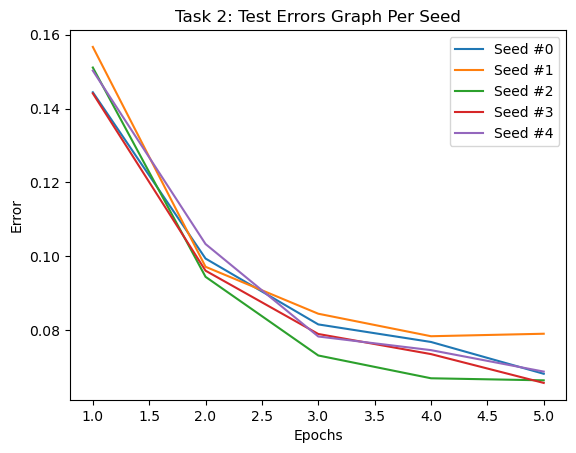

In [21]:
# Graphs for each seed
for i,curr_training_tests_error in enumerate(training_tests_errors):
    x_axis = np.arange(1, len(curr_training_tests_error) + 1) # so x axis is from 1 to 5
    plt.plot(x_axis,curr_training_tests_error, label=f'Seed #{i}')

plt.ylabel("Error")
plt.xlabel("Epochs")
plt.title("Task 2: Test Errors Graph Per Seed")
# plt.yscale('log')
# plt.xscale('log')
plt.legend()
plt.show()

In [22]:
# Calculate mean and standard deviation of the final test errors
print(f'Mean of test errors: {np.mean(final_tests_errors)}, Standard Deviation: {np.std(final_tests_errors)}, Variance: {np.var(final_tests_errors)}')

Mean of test errors: 0.06951344150380465, Standard Deviation: 0.004841769944304654, Variance: 2.344273619357189e-05
